In [1]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

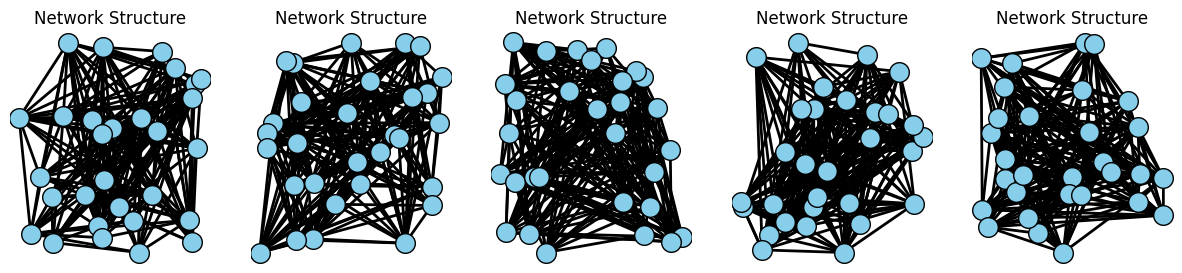

In [2]:
def generate_random_network(num_nodes):
    adjacency_matrix = np.random.choice([0, 1], size=(num_nodes, num_nodes))
    np.fill_diagonal(adjacency_matrix, 0)
    return adjacency_matrix

def plot_network(adjacency_matrix, ax):
    num_nodes = len(adjacency_matrix)
    positions = np.random.rand(num_nodes, 2)
    
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adjacency_matrix[i, j] == 1:
                ax.plot([positions[i, 0], positions[j, 0]], [positions[i, 1], positions[j, 1]], 'k-', lw=2)

    ax.scatter(positions[:, 0], positions[:, 1], c='skyblue', s=200, edgecolors='black', linewidths=1, zorder=10)
    ax.set_title("Network Structure")

# 生成5个随机网络
num_nodes = 30
networks = [generate_random_network(num_nodes) for _ in range(5)]

# 绘制网络图
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, network in enumerate(networks):
    axes[i].set_title(f'Network{i + 1}')
    plot_network(network, axes[i])
    axes[i].axis('off')

plt.show()

In [25]:
def SIR(adjacency_matrix, start_node=0, infection_rate=0.01, recovery_rate=0.3):
    # 初始化节点状态
    susceptible_nodes = set(range(adjacency_matrix.shape[0])) - {start_node}
    infected_nodes = {start_node}
    recovered_nodes = set()

    # 记录模拟数据
    simulation_data = {"susceptible": [len(susceptible_nodes)], "infected": [len(infected_nodes)], "recovered": [len(recovered_nodes)]}

    # 如果还有感染者，模拟过程继续
    while infected_nodes:
        new_infected_nodes = set()
        new_recovered_nodes = set()

        for current_infected_node in infected_nodes:
            # 找到与之相邻的所有结点
            neighbors = set(filter(lambda node: node in susceptible_nodes, np.nonzero(adjacency_matrix[current_infected_node])[0]))

            # 按感染率随机感染邻居
            new_infected_nodes |= set(filter(lambda neighbor: np.random.rand() < infection_rate, neighbors))
            
            # 按康复率随机康复
            new_recovered_nodes |= set(filter(lambda node: np.random.rand() < recovery_rate, infected_nodes))

        susceptible_nodes -= new_infected_nodes
        infected_nodes = (infected_nodes | new_infected_nodes) - new_recovered_nodes
        recovered_nodes |= new_recovered_nodes
        simulation_data["susceptible"].append(len(susceptible_nodes))
        simulation_data["infected"].append(len(infected_nodes))
        simulation_data["recovered"].append(len(recovered_nodes))

    return simulation_data

In [26]:
def SIR_sort(network):
    with_importance_nodes = [
        (node, SIR(network, node)["recovered"][-1])
        for node in range(network.shape[0])
    ]
    order = sorted(with_importance_nodes, key=lambda pair: pair[1])
    return order

In [27]:
def k_shell_sort(network):
    network = network.astype(float)
    degrees = np.asarray([np.sum(row) for row in network])
    order = []

    while len(order) < network.shape[0]:
        min_degree = np.min(degrees)
        min_degree_nodes = np.nonzero(degrees == min_degree)[0]
        network[:, min_degree_nodes] = 0
        network[min_degree_nodes, :] = np.inf
        degrees = np.sum(network, axis=1)
        order.extend((node, int(min_degree)) for node in min_degree_nodes)
    return order

In [28]:
def group_nodes_by_distance(network, source):
    """
    使用广度优先搜索将网络节点按距离分组。
    """
    layers = defaultdict(list)
    queue = [(source, 0)]
    visited = {source}

    while queue:
        node, distance = queue.pop(0)
        layers[distance].append(node)

        neighbors = np.nonzero(network[node])[0]
        unvisited_neighbors = set(neighbors) - visited
        queue.extend((neighbor, distance + 1) for neighbor in unvisited_neighbors)
        visited |= unvisited_neighbors

    return [layers[distance] for distance in sorted(layers.keys())]

def calcu_prob_w(network, source, beta):
    """
    计算节点的感染概率。
    """
    scores = np.zeros(network.shape[0])
    scores[source] = 1
    layers = group_nodes_by_distance(network, source)

    # 计算前三层每个节点的感染分数
    for layer_index, layer in enumerate(layers[1:4]):
        for node in layer:
            # 找到该节点处于前一层的邻居
            neighbors = np.nonzero(network[node])[0]
            influencers = np.intersect1d(neighbors, layers[layer_index])
            # 根据这些邻居的感染分数，计算该节点的感染分数
            scores[node] = 1 - np.prod(1 - scores[influencers] * beta)

    importance = np.round(np.sum(scores) - 1, 3)

    return importance

def prob_sort(network, beta=0.3):
    """
    根据感染概率对网络节点进行排序。
    """
    with_importance_nodes = [
        (node, calcu_prob_w(network, node, beta))
        for node in range(network.shape[0])
    ]
    order = sorted(with_importance_nodes, key=lambda pair: pair[1])
    return order

In [29]:
# 计算两个序列的相关性
def calcu_conv(sequence1, sequence2):
    # 逐一比较每一个变化对的正相关性和负相关性
    pairs = list(zip(sequence1, sequence2))
    num_positive = 0
    num_negative = 0

    for index, (x1, y1) in enumerate(pairs[:-1]):
        for x2, y2 in pairs[index + 1 :]:
            num_positive += 1 if (x1 < x2 and y1 < y2) or (x1 > x2 and y1 > y2) else 0
            num_negative += 1 if (x1 < x2 and y1 > y2) or (x1 > x2 and y1 < y2) else 0

    correlation = np.round((num_positive - num_negative) / np.sum(range(len(sequence1))), 3)

    return correlation

In [30]:
for index, network in enumerate(networks):
    SIR_sequence = [pair[0] for pair in SIR_sort(network)]
    k_shell_sequence = [pair[0] for pair in k_shell_sort(network)]
    prob_sequence = [pair[0] for pair in prob_sort(network)]
    SIR_k = calcu_conv(SIR_sequence,k_shell_sequence)
    SIR_p = calcu_conv(SIR_sequence, prob_sequence)
    
    print("-"*100)
    print(index + 1, "号网络")
    print("SIR序列：", SIR_sequence)
    print("k-shell序列：", k_shell_sequence)
    print("概率序列：", prob_sequence)
    print("SIR与k-shell相关性:", SIR_k)
    print("SIR与概率排序相关性:", SIR_p)

----------------------------------------------------------------------------------------------------
1 号网络
SIR序列： [0, 3, 6, 8, 9, 10, 11, 13, 14, 15, 16, 19, 20, 23, 24, 26, 27, 28, 29, 1, 2, 4, 5, 12, 17, 22, 25, 7, 21, 18]
k-shell序列： [11, 0, 14, 16, 13, 2, 5, 8, 28, 1, 10, 23, 29, 22, 19, 6, 15, 18, 20, 24, 3, 17, 7, 9, 25, 27, 4, 12, 21, 26]
概率序列： [13, 11, 29, 4, 7, 9, 14, 28, 8, 0, 27, 18, 22, 5, 16, 3, 26, 23, 1, 20, 25, 12, 24, 15, 2, 6, 19, 17, 21, 10]
SIR与k-shell相关性: 0.191
SIR与概率排序相关性: -0.094
----------------------------------------------------------------------------------------------------
2 号网络
SIR序列： [0, 2, 5, 6, 8, 9, 12, 13, 14, 16, 18, 20, 24, 25, 28, 4, 11, 17, 22, 23, 26, 27, 1, 10, 15, 19, 3, 21, 7, 29]
k-shell序列： [28, 26, 20, 0, 10, 19, 22, 24, 8, 9, 23, 4, 7, 11, 27, 1, 3, 15, 16, 25, 13, 5, 12, 2, 21, 6, 14, 17, 18, 29]
概率序列： [9, 29, 11, 21, 16, 19, 26, 8, 17, 25, 22, 4, 18, 13, 27, 10, 28, 23, 12, 20, 7, 24, 15, 14, 6, 3, 1, 0, 5, 2]
SIR与k-shell相关性: 0.053
SIR与概率排序